<a href="https://colab.research.google.com/github/LoveTechCode/Modulo1/blob/master/Primeros_pasos_con_tensor_flow_Enrique_Cabello.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Copyright 2017 Google LLC.

In [1]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

 # Primeros pasos con TensorFlow

 Recuerda hacer una copia de este archivo, para poder trabajar en tu cuaderno    
 **Objetivos de aprendizaje:**
  * Aprender los conceptos fundamentales de TensorFlow
  * Usar la clase `LinearRegressor` en TensorFlow para predecir el precio medio de la vivienda, en el nivel de detalle de las manzanas, basado en un atributo de entrada
  * Evaluar la exactitud de las predicciones de un modelo a través del error de la raíz cuadrada de la media (RMSE)
  * Mejorar la exactitud de un modelo al ajustar sus hiperparámetros
  * Tendrás que investigar bastantes cosas por tu cuenta y comentar las lineas de código que consideres oportunas, cuantas mejor mejor. Investiga, Investiga e Investiga... 
  Luego puedes compartir conmigo tu trabajo para revisarlo. 
  * Suerte!!



 Los datos se basan en el censo que se realizó en 1990 en California.

 ## Preparación
En esta primera celda, cargaremos las bibliotecas necesarias.

In [2]:
from __future__ import print_function
#Estudia las librerías que utilizamos en el ejemplo. 
 
import math
# !! INVESTIGA POR TI MISMO QUE LIBRERIAS ESTAMOS IMPORTANDO. 
from IPython import display # IPython añade funcionalidades extras, resaltado de codigo, autocompletado..
from matplotlib import cm  # para mapas de color 
from matplotlib import gridspec #permite crear graficos en subparcelas independientes
from matplotlib import pyplot as plt 
import numpy as np
import pandas as pd
from sklearn import metrics # implementa funciones para evaluar el error de nuestro modelo
%tensorflow_version 1.x
import tensorflow as tf
from tensorflow.python.data import Dataset
 
tf.logging.set_verbosity(tf.logging.ERROR) # configuración de errores por pantalla
pd.options.display.max_rows = 10 #maximo de filas cuando imprimimos datos
pd.options.display.float_format = '{:.1f}'.format

TensorFlow 1.x selected.


 A continuación, cargaremos nuestro conjunto de datos.

In [3]:
california_viviendas_dataframe = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=",")

 Dispondremos los datos de forma aleatoria para no tener efectos de sobreajuste que podrían afectar el rendimiento del descenso de gradiente estocástico. Además, ajustaremos `median_house_value` para que esté en unidades de miles, de manera que se pueda trabajar más fácilmente con tasas de aprendizaje en un rango mas sencillo.

In [4]:
california_viviendas_dataframe = california_viviendas_dataframe.reindex(
    np.random.permutation(california_viviendas_dataframe.index))
california_viviendas_dataframe["median_house_value"] /= 1000.0
california_viviendas_dataframe

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
8837,-118.7,34.2,28.0,2405.0,462.0,1011.0,378.0,4.5,204.3
2592,-117.7,35.6,11.0,5897.0,1138.0,2728.0,1072.0,4.2,85.7
5622,-118.2,34.1,33.0,278.0,71.0,266.0,56.0,0.9,98.2
2793,-117.7,33.6,16.0,2497.0,500.0,1357.0,456.0,4.6,241.8
7562,-118.4,33.9,36.0,681.0,122.0,360.0,128.0,5.3,332.6
...,...,...,...,...,...,...,...,...,...
15191,-122.3,37.9,42.0,1650.0,274.0,645.0,256.0,5.6,375.4
2365,-117.5,34.1,21.0,2455.0,381.0,1094.0,327.0,4.6,191.7
15492,-122.3,38.0,37.0,1887.0,353.0,895.0,359.0,4.5,196.6
798,-117.1,33.7,16.0,4928.0,960.0,2132.0,853.0,2.8,112.5


 ## Análisis de los datos

Una buena idea es conocer un poco los datos antes de trabajar con ellos.

Imprimiremos un breve resumen de algunas estadísticas útiles de cada columna: conteo de ejemplos, media, desviación estándar, máx., mín. y la distribución en cuartiles.

In [5]:
california_viviendas_dataframe.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0
mean,-119.6,35.6,28.6,2643.7,539.4,1429.6,501.2,3.9,207.3
std,2.0,2.1,12.6,2179.9,421.5,1147.9,384.5,1.9,116.0
min,-124.3,32.5,1.0,2.0,1.0,3.0,1.0,0.5,15.0
25%,-121.8,33.9,18.0,1462.0,297.0,790.0,282.0,2.6,119.4
50%,-118.5,34.2,29.0,2127.0,434.0,1167.0,409.0,3.5,180.4
75%,-118.0,37.7,37.0,3151.2,648.2,1721.0,605.2,4.8,265.0
max,-114.3,42.0,52.0,37937.0,6445.0,35682.0,6082.0,15.0,500.0


 ## Creación del primer modelo

En este ejercicio, intentaremos predecir `median_house_value`, que será nuestra etiqueta (a veces también denominada objetivo). Usaremos `total_rooms` como nuestro atributo de entrada.

**NOTA:** Nuestros datos están a nivel de manzana, de manera que este atributo representa el número total de habitaciones en esa manzana.

Para entrenar nuestro modelo, usaremos la interfaz de [LinearRegressor](https://www.tensorflow.org/api_docs/python/tf/estimator/LinearRegressor) que proporciona la API de [Estimator](https://www.tensorflow.org/get_started/estimator) de TensorFlow. Esta API se ocupa en gran medida del ajuste del modelo de bajo nivel y presenta métodos convenientes para realizar el entrenamiento, la evaluación y la inferencia del modelo.

 ### Paso 1: Define atributos y configura columnas de atributos

 Para importar nuestros datos de entrenamiento en TensorFlow, debemos especificar qué tipo de datos contiene cada atributo. Hay dos tipos de datos principales que usaremos en este ejercicio y en otros futuros:

* **Datos categóricos**: Datos que son textuales. En este ejercicio, nuestro conjunto de datos de viviendas no contiene atributos categóricos, pero los ejemplos que podrías ver son el tipo de la casa (chalet, apartamento...)
* **Datos numéricos**: Datos que son un número (entero o de punto flotante) y que quieres tratar como un número. Como se analizará más adelante, a veces quieres tratar los datos numéricos (p. ej., un código postal) como si fueran categóricos.

En TensorFlow, indicamos el tipo de datos de un atributo a través de un constructor denominado **columna de atributos**. **Las columnas de atributos almacenan solo una descripción de los datos de los atributos; no contienen los datos de los atributos en sí.**

Para comenzar, usaremos solo un atributo de entrada numérica, `total_rooms`. El siguiente código extrae los datos de `total_rooms` de nuestro `california_viviendas_dataframe` y define la columna de atributos con `numeric_column`, que especifica que los datos son numéricos:

In [6]:
# Definimos la característica de entrada: total_rooms.
mi_caracteristica_input = california_viviendas_dataframe[["total_rooms"]]
mi_caracteristica_input

,total_rooms
8837,2405.0
2592,5897.0
5622,278.0
2793,2497.0
7562,681.0
...,...
15191,1650.0
2365,2455.0
15492,1887.0
798,4928.0


In [7]:
type(mi_caracteristica_input)

pandas.core.frame.DataFrame

In [8]:
# Configuramos la columna de atributos como númerica
columna_atributos = [tf.feature_column.numeric_column("total_rooms")]
print(columna_atributos)

[NumericColumn(key='total_rooms', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]


In [9]:
type(columna_atributos)

list

 **NOTA:** La forma de nuestros datos de `total_rooms` es una matriz de una dimensión (una lista del número total de habitaciones por cada manzana). Esta es la forma predeterminada para `numeric_column`, de manera que no tenemos que pasarla como un argumento.

 ### Paso 2: Define el objetivo

 A continuación, definiremos nuestro objetivo, que es `median_house_value`. Nuevamente, podemos extraerlo de nuestro `california_viviendas_dataframe`:

In [10]:
# Definimos nuestro objetivo
objetivo_median_house_value = california_viviendas_dataframe["median_house_value"]
objetivo_median_house_value

8837    204.3
2592     85.7
5622     98.2
2793    241.8
7562    332.6
         ... 
15191   375.4
2365    191.7
15492   196.6
798     112.5
5900    200.8
Name: median_house_value, Length: 17000, dtype: float64

In [11]:
type(objetivo_median_house_value)

pandas.core.series.Series

 ### Paso 3: Configura el regresor lineal

 A continuación, configuraremos un modelo de regresión lineal a través de LinearRegressor. Entrenaremos este modelo mediante el `GradientDescentOptimizer`, que implementa el descenso de gradiente estocástico (SGD) de minilote. El argumento `learning_rate` controla el tamaño del paso de gradiente.

**NOTA:** Para estar seguros, también aplicamos recorte de gradientes, ( para prevenir el crecimiento excesivo de esta función ) a nuestro optimizador a través de `clip_gradients_by_norm`. El recorte de gradientes garantiza que la magnitud de los gradientes no se vuelva demasiado grande durante el entrenamiento, lo cual puede provocar que falle el descenso de gradientes. 

In [12]:
# Definimos los parametros learning_rate (saltos incrementales en el sgd)
# y el parametro clip_gradients que regula los valores maximos y minimos que pueden tomar (-5, +5)
my_optimizador = tf.train.GradientDescentOptimizer(learning_rate=0.0000001)
my_optimizador = tf.contrib.estimator.clip_gradients_by_norm(my_optimizador, 5.0)
 
# Configuramos el estimador LinearRegressor con los parametros anteriores y las features (valores x)
modelo_regresion_lineal = tf.estimator.LinearRegressor(
    feature_columns=columna_atributos,
    optimizer=my_optimizador
)

 ### Paso 4: Define la función de entrada

 Para importar nuestros datos de viviendas en California a nuestro `LinearRegressor`, tenemos que definir una función de entrada, que instruye a TensorFlow cómo realizar el procesamiento previo de los datos, además de cómo organizarlos por lotes, aleatorizarlos y repetirlos durante el entrenamiento del modelo.

Primero, convertiremos nuestros datos de atributos de *pandas* a un diccionario de matrices de Numpy. A continuación, podemos usar la [API del conjunto de datos](https://www.tensorflow.org/programmers_guide/datasets) de TensorFlow para construir un objeto de conjunto de datos a partir de nuestros datos y, luego, dividir nuestros datos en lotes de `batch_size` para que se repitan para el número especificado de repeticiones (num_epochs). 

**NOTA:** Cuando el valor predeterminado de `num_epochs=None` se pasa como argumento a la función `repeat()`, los datos de entrada se repiten indefinidamente.

A continuación, si `shuffle` está establecido en `True`, se aleatorizarán los datos de manera tal que se pasen al modelo al azar durante el entrenamiento. El argumento `buffer_size` de la función `shuffle` especifica el tamaño del conjunto de datos del que se tomará una muestra al azar.

Finalmente, nuestra función de entrada construye una variable de iteración para el conjunto de datos y devuelve el siguiente lote de datos al regresor lineal.

In [13]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=100):
    """Entrenamiento de un modelo Lineal 
  
    Args:
      features: Un DataFrame de Pandas
      targets: DataFrame de objetivos Pandas.
      batch_size: Tamaño del lote que le pasamos al modelo
      shuffle: True or False. Sirve para mezclar los datos
      num_epochs: Numero de epochs
   
    """
  
    # Convierte los datos de Pandas en un diccionario de matrices O TENSOR
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Creamos un nuevo dataset cuyos elementos son trozos del tensor (fetaures, targets). 
    # El tensor se trocea a lo largo de su primera dimension.
    ds = Dataset.from_tensor_slices((features,targets)) # maximo 2GB
    ds = ds.batch(batch_size).repeat(num_epochs)
    
 
    if shuffle:
      ds = ds.shuffle(buffer_size=10000)
    
    # construye una variable de iteración para el conjunto de datos y devuelve el siguiente lote de datos al regresor lineal
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

 **NOTA:** Seguiremos usando esta misma función de entrada en ejercicios posteriores. Para obtener documentación más detallada de las funciones de entrada y la API del `Dataset`, consulta la [Guía para programadores de TensorFlow](https://www.tensorflow.org/programmers_guide/datasets).

In [14]:
# mi_caracteristica_input = {key:np.array(value) for key,value in dict(mi_caracteristica_input).items()}                                           
# 
# mi_caracteristica_input


In [15]:
# my_input_fn = lambda:my_input_fn(mi_caracteristica_input, objetivo_median_house_value)
# my_input_fn

 ### Paso 5: Entrena el modelo

 Ahora podemos llamar a `train()` en nuestro `linear_regressor` para entrenar el modelo. Uniremos `my_input_fn` en una `lambda` para poder pasar `mi_caracteristica_input` y `objetivo_median_house_value` como argumentos (para obtener más detalles, consulta este [instructivo sobre funciones de entrada de TensorFlow](https://www.tensorflow.org/get_started/input_fn#passing_input_fn_data_to_your_model)) y, para comenzar, entrenaremos el modelo para 100 pasos. 
Un paso calcula la pérdida de un lote y usa ese valor para modificar los pesos del modelo una vez.

In [16]:
#def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=100):

_ = modelo_regresion_lineal.train(
    input_fn = lambda:my_input_fn(mi_caracteristica_input, objetivo_median_house_value),
    steps=100
)

 ### Paso 6: Evalúa el modelo

 Realicemos predicciones sobre los datos de entrenamiento para ver qué tan bien los ajustó nuestro modelo durante el entrenamiento.
**NOTA:** El error de entrenamiento mide qué tan bien ajusta los datos de entrenamiento tu modelo, pero **_no_** mide qué tan bien el modelo **_realiza generalizaciones con respecto a los datos nuevos_**. En ejercicios posteriores, explorarás cómo dividir los datos para evaluar la capacidad del modelo para realizar generalizaciones.


In [17]:
# Creamos una función de entrada para las predicciones
# Nota: Dado que hacemos una predicción por cada ejemplo no
# no necesitamos volver a mezclar los datos
prediction_input_fn =lambda: my_input_fn(mi_caracteristica_input, objetivo_median_house_value, num_epochs=1, shuffle=False)

# Evaluamos el modelo que hemos entrado anteriormente
# Usamos elmismo conjunto de features??? no hemos hecho split entre train y eval???

predictions = modelo_regresion_lineal.predict(input_fn=prediction_input_fn)

# Pasamos los resultados a un Numpy array
predictions = np.array([item['predictions'][0] for item in predictions])
predictions

array([0.12025001, 0.29485   , 0.01390003, ..., 0.09435001, 0.24639998,
       0.05045002], dtype=float32)

In [18]:
# Calculamos el MSE y RMSE
# segun la funcion metrics.mean_squared_error(y_true, y_pred)
# Aqui los hemos metido al reves
mean_squared_error = metrics.mean_squared_error(predictions, objetivo_median_house_value)
root_mean_squared_error = math.sqrt(mean_squared_error)

print("Mean Squared Error (Durante el entrenamiento): %0.3f" % mean_squared_error)
print("Root Mean Squared Error (Durante el entrenamiento): %0.3f" % root_mean_squared_error)

Mean Squared Error (Durante el entrenamiento): 56367.025
Root Mean Squared Error (Durante el entrenamiento): 237.417


 ¿Este es un buen modelo? ¿Cómo determinarías la magnitud de este error?

El error cuadrático medio (MSE) puede ser difícil de interpretar; es por esto que generalmente observamos el error de la raíz cuadrada de la media (RMSE) en su lugar. Una propiedad interesante del RMSE es que se puede interpretar en la misma escala que los objetivos originales.

Comparemos el RMSE con la diferencia del mín. y el máx. de nuestros objetivos:

In [19]:
min_house_value = california_viviendas_dataframe["median_house_value"].min()
max_house_value = california_viviendas_dataframe["median_house_value"].max()
min_max_difference = max_house_value - min_house_value

print("Min. Median House Value: %0.3f" % min_house_value)
print("Max. Median House Value: %0.3f" % max_house_value)
print("Differencia entre Min. and Max.: %0.3f" % min_max_difference)
print("Root Mean Squared Error: %0.3f" % root_mean_squared_error)

Min. Median House Value: 14.999
Max. Median House Value: 500.001
Differencia entre Min. and Max.: 485.002
Root Mean Squared Error: 237.417


 Nuestro error abarca casi la mitad del rango de los valores objetivo. ¿Podemos obtener un mejor desempeño?

Esta es la pregunta que molesta a todo programador de modelos. Desarrollemos algunas estrategias básicas para reducir el error del modelo.

Lo primero que podemos hacer es observar qué tan bien coinciden nuestras predicciones con nuestros objetivos, en términos de estadísticas generales de resumen.

In [20]:
calibration_data = pd.DataFrame()
calibration_data["predictions"] = pd.Series(predictions)
calibration_data["objetivos"] = pd.Series(objetivo_median_house_value)
calibration_data.describe()

,predictions,objetivos
count,17000.0,17000.0
mean,0.1,207.3
std,0.1,116.0
min,0.0,15.0
25%,0.1,119.4
50%,0.1,180.4
75%,0.2,265.0
max,1.9,500.0


 Bien, es posible que esta información resulte útil. ¿Cómo se compara el valor medio con el RMSE del modelo? ¿Qué ocurre con los diferentes cuantiles?

También podemos visualizar los datos y la línea que aprendimos. Recuerda que la regresión lineal en un solo atributo puede representarse como una línea que asigna la entrada *x* al resultado *y*.

Primero, obtendremos una muestra aleatoria uniforme de los datos para poder realizar una representación de dispersión que se pueda leer.

In [21]:
sample = california_viviendas_dataframe.sample(n=300)

 A continuación, representaremos la línea que aprendimos, dibujándola a partir del término de ordenada al origen y la ponderación del atributo del modelo, junto con la representación de dispersión. La línea se mostrará de color rojo.

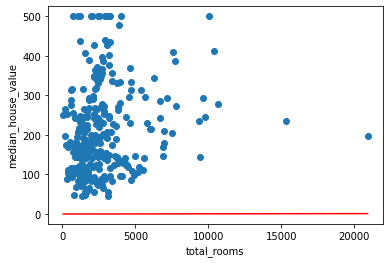

In [22]:
# Establece los valores minimos y maximos de total_rooms
x_0 = sample["total_rooms"].min()
x_1 = sample["total_rooms"].max()

# Guardamos los pesos calculados por el modelo
weight = modelo_regresion_lineal.get_variable_value('linear/linear_model/total_rooms/weights')[0]
bias = modelo_regresion_lineal.get_variable_value('linear/linear_model/bias_weights')

# Obtenemos los median_house_values previstos para los valores mínimos y máximos de total_rooms.
y_0 = weight * x_0 + bias 
y_1 = weight * x_1 + bias

# Trazamos nuestra linea de regresion desde (x_0, y_0) to (x_1, y_1).
plt.plot([x_0, x_1], [y_0, y_1], c='r')

# Nombramos los ejes x e y de la grafica
plt.ylabel("median_house_value")
plt.xlabel("total_rooms")

# Representamos una muestra aleatoria de "total_rooms" y "median_house_value"
plt.scatter(sample["total_rooms"], sample["median_house_value"])

# Presenta el grafico en pantalla
plt.show()

 Esta línea inicial se ve muy alejada. Fíjate si puedes observar las estadísticas de resumen y ver la misma información codificada allí.

En conjunto, estos controles de estado sugieren que posiblemente podamos encontrar una línea mucho más satisfactoria.

 ## Ajuste de los hiperparámetros del modelo
Para este ejercicio, colocamos todo el código anterior en una sola función por cuestiones prácticas. Puedes llamar a la función con diferentes parámetros para ver el efecto.

En esta función, procederemos en 10 períodos divididos uniformemente para poder observar la mejora del modelo en cada período.

Para cada período, computaremos y graficaremos la pérdida de entrenamiento. Esto puede ayudarte a determinar cuándo converge un modelo o si este necesita más iteraciones.

También representaremos los valores de ponderación de atributos y término de ordenada al origen aprendidos por el modelo en el tiempo. Esta es otra forma de ver cómo convergen los elementos.

In [23]:
def train_model(learning_rate, steps, batch_size, input_feature="total_rooms"):
  """Entrena un modelo de Regresión Lineal de una caracteristica.
  
  Args:
    learning_rate: tasa de aprendizaje
    steps: pasos del entrenamiento
    batch_size: Tamaño del lote.
    input_feature: Un String que especifica una columna`california_viviendas_dataframe`
      para usar como caracteristica de entrada
  """
  
  periods = 10
  steps_per_period = steps / periods

  my_feature = input_feature
  my_feature_data = california_viviendas_dataframe[[my_feature]]
  my_label = "median_house_value"
  targets = california_viviendas_dataframe[my_label]

  # Damos formato numerico a los valores de la columna
  feature_columns = [tf.feature_column.numeric_column(my_feature)]
  
  # Definimos las funciones input_fn para el modelo
  training_input_fn = lambda:my_input_fn(my_feature_data, targets, batch_size=batch_size)
  prediction_input_fn = lambda: my_input_fn(my_feature_data, targets, num_epochs=1, shuffle=False)
  
  # Construimos el optimizador y el estimador
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=feature_columns,
      optimizer=my_optimizer
  )

  # Preparamos la representacion grafica de los resultados
  # Representacion de la grafica izquierda del frame
  plt.figure(figsize=(15, 6))
  plt.subplot(1, 2, 1)
  plt.title("Learned Line by Period")
  plt.ylabel(my_label)
  plt.xlabel(my_feature)
  sample = california_viviendas_dataframe.sample(n=300)
  plt.scatter(sample[my_feature], sample[my_label])
  colors = [cm.coolwarm(x) for x in np.linspace(-1, 1, periods)]

  # Entrenamos el modelo dentro de un bucle para evaluar perdidas periodicamente

  print("Entrenando el modelo...")
  print("RMSE (en datos de entrenamiento):")
  root_mean_squared_errors = []
  for period in range (0, periods):
    # 
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Toma un descanso y computa predicciones
    predictions = linear_regressor.predict(input_fn=prediction_input_fn)
    predictions = np.array([item['predictions'][0] for item in predictions])
    
    # Computa perdidas.
    root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(predictions, targets))
    # Ocasionalmente imprime la perdida actual
    print("  periodo %02d : %0.2f" % (period, root_mean_squared_error))
    # Agrega las metricas de perdida de este periodo a nuestra lista
    root_mean_squared_errors.append(root_mean_squared_error)
    # Finalmente, realiza un seguimiento de los pesos y los sesgos a lo largo del tiempo.
    # 
    y_extents = np.array([0, sample[my_label].max()])
    
    weight = linear_regressor.get_variable_value('linear/linear_model/%s/weights' % input_feature)[0]
    bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')

    x_extents = (y_extents - bias) / weight
    x_extents = np.maximum(np.minimum(x_extents,
                                      sample[my_feature].max()),
                           sample[my_feature].min())
    y_extents = weight * x_extents + bias
    plt.plot(x_extents, y_extents, color=colors[period]) 
  print("Entrenamiento del modelo Finalizado.")

  # Genera el grafico de metricas
  # Representacion de la grafica derecha del frame
  plt.subplot(1, 2, 2)
  plt.ylabel('RMSE')
  plt.xlabel('Periodos')
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(root_mean_squared_errors)

  # Pinta la tabla con los datos de calibración.
  calibration_data = pd.DataFrame()
  calibration_data["predictions"] = pd.Series(predictions)
  calibration_data["targets"] = pd.Series(targets)
  display.display(calibration_data.describe())

  print("Final RMSE (on training data): %0.2f" % root_mean_squared_error)

 ## Tarea 1: Logra un RMSE de 180 o más bajo

Ajusta los hiperparámetros del modelo para mejorar la pérdida y adaptar mejor la distribución objetivo.
Si después de aproximadamente 5 minutos tienes problemas para obtener un RMSE de 180 o más bajo, comprueba la solución para conocer una combinación posible.

Entrenando el modelo...
RMSE (en datos de entrenamiento):
  periodo 00 : 236.32
  periodo 01 : 235.11
  periodo 02 : 233.90
  periodo 03 : 232.70
  periodo 04 : 231.50
  periodo 05 : 230.31
  periodo 06 : 229.13
  periodo 07 : 227.96
  periodo 08 : 226.79
  periodo 09 : 225.63
Entrenamiento del modelo Finalizado.


,predictions,targets
count,17000.0,17000.0
mean,13.2,207.3
std,10.9,116.0
min,0.0,15.0
25%,7.3,119.4
50%,10.6,180.4
75%,15.8,265.0
max,189.7,500.0


Final RMSE (on training data): 225.63


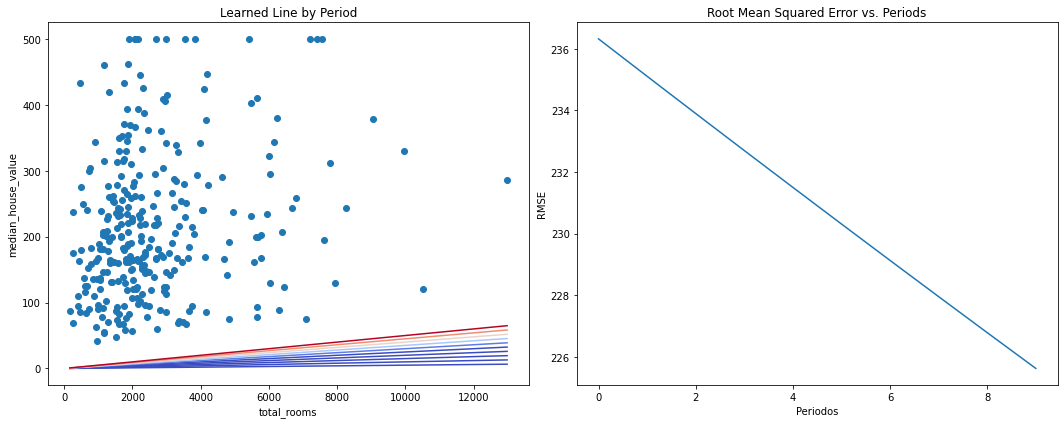

In [28]:
train_model(
    learning_rate=0.00001,
    steps=100,
    batch_size=1
)

In [ ]:
######################################################################################
### NOTA: estamos haciendo predecciones con el mismo dataset de training ???
######################################################################################

### ## los lotes no influyen a la hora de entrenar (salvo por la reduccion de recursos de computacion)
### train_model(
###     learning_rate=0.00001,
###     steps=1000,
###     batch_size=20
### )
### #### Final SME: 167.74
### 
### train_model(
###     learning_rate=0.00001,
###     steps=1000,
###     batch_size=30
### )
### #### Final SME: 167.34
### 
### ## el numero de epochs si influye
### train_model(
###     learning_rate=0.00001,
###     steps=800,
###     batch_size=20
### )
### #### Final SME: 171.23

### Reduciendo learning rates va muy lento aprendiendo y no llegamos al SME
### train_model(
###     learning_rate=0.000001,
###     steps=800,
###     batch_size=20
### )
### #### Final SME: 

### Aumentando learning rates aprende demasiado rapido pero los parametros estadisticos (mean, std) varian mucho
### ademas, el SME parcial no decrece de manera constante

Entrenando el modelo...
RMSE (en datos de entrenamiento):
  periodo 00 : 187.07
  periodo 01 : 167.37
  periodo 02 : 168.56
  periodo 03 : 168.04
  periodo 04 : 168.29
  periodo 05 : 168.57
  periodo 06 : 169.48
  periodo 07 : 169.48
  periodo 08 : 169.82
  periodo 09 : 169.82
Entrenamiento del modelo Finalizado.


,predictions,targets
count,17000.0,17000.0
mean,157.4,207.3
std,129.8,116.0
min,0.1,15.0
25%,87.0,119.4
50%,126.6,180.4
75%,187.6,265.0
max,2258.1,500.0


Final RMSE (on training data): 169.82


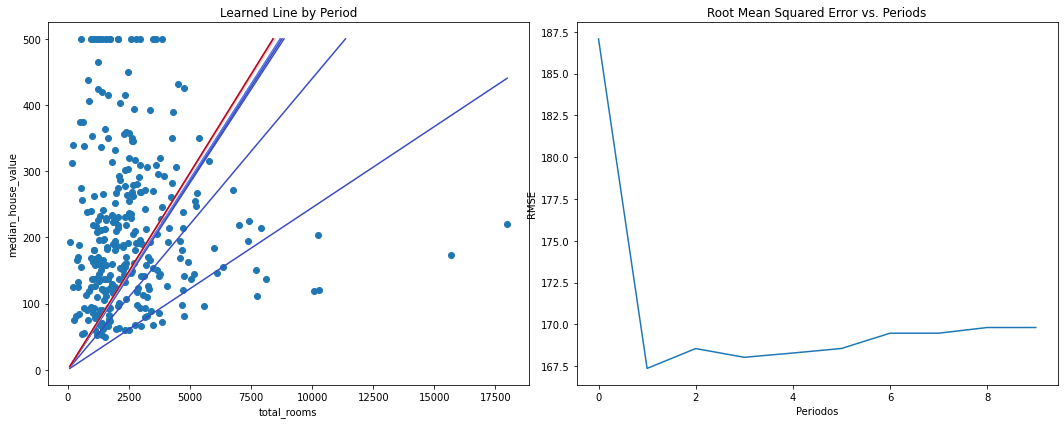

In [35]:
train_model(
    learning_rate=0.00005,
    steps=1000,
    batch_size=20
)

 ### Solución

Haz clic más abajo para conocer una solución posible.

Entrenando el modelo...
RMSE (en datos de entrenamiento):
  periodo 00 : 225.63
  periodo 01 : 214.42
  periodo 02 : 204.04
  periodo 03 : 194.97
  periodo 04 : 186.92
  periodo 05 : 180.27
  periodo 06 : 175.18
  periodo 07 : 172.05
  periodo 08 : 169.44
  periodo 09 : 167.21
Entrenamiento del modelo Finalizado.


,predictions,targets
count,17000.0,17000.0
mean,117.5,207.3
std,96.9,116.0
min,0.1,15.0
25%,65.0,119.4
50%,94.5,180.4
75%,140.0,265.0
max,1685.7,500.0


Final RMSE (on training data): 167.21


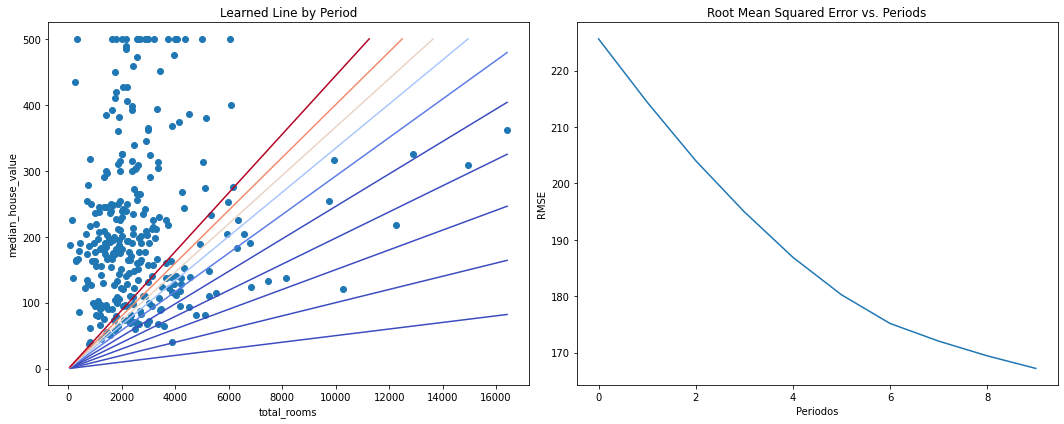

In [25]:
train_model(
    learning_rate=0.00002,
    steps=500,
    batch_size=5
)

 Esta es solo una configuración posible; es posible que existan otras combinaciones de configuraciones que también den buenos resultados. Ten en cuenta que, en general, este ejercicio no se trata de buscar la *mejor* configuración, sino de ayudarte a desarrollar tu intuición sobre cómo el ajuste de la configuración del modelo afecta la calidad de la predicción.

 ### ¿Hay una heurística estándar para el ajuste del modelo?

Esta es una pregunta frecuente. La respuesta breve es que los efectos de los diferentes hiperparámetros dependen de los datos. Por lo tanto, no hay reglas estrictas; debes probarlos en tus datos.

Dicho esto, aquí se incluyen algunas reglas generales que pueden ayudarte como guía:

 * El error de entrenamiento debe disminuir constantemente, de manera abrupta al principio y eventualmente estancarse a medida que converge el entrenamiento.
 * Si el entrenamiento no convirgió, prueba ejecutarlo durante más tiempo.
 * Si el error de entrenamiento disminuye muy lentamente, aumentar la tasa de entrenamiento puede ayudar a que disminuya más rápido.
   * Sin embargo, en algunas ocasiones puede ocurrir exactamente lo opuesto si la tasa de aprendizaje es demasiado alta.
 * Si el error de entrenamiento varía extremadamente, prueba disminuir la tasa de aprendizaje.
   * Una tasa de aprendizaje más baja con un número más alto de pasos o un tamaño del lote más grande suelen ser una buena combinación.
 * Los tamaños del lote muy pequeños también pueden causar inestabilidad. Primero prueba valores más altos, como 100 o 1,000, y disminúyelos hasta que observes degradación.

Como dijimos antes, nunca te rijas estrictamente por estas reglas generales, porque los efectos dependen de los datos. Siempre debes experimentar y verificar.

 ## Tarea 2: Prueba un atributo diferente

Observa si puedes obtener un mejor desempeño al reemplazar el atributo `total_rooms` por el atributo `population`.

No dediques más de 5 minutos a esta actividad.

Entrenando el modelo...
RMSE (en datos de entrenamiento):
  periodo 00 : 231.48
  periodo 01 : 225.74
  periodo 02 : 220.11
  periodo 03 : 214.83
  periodo 04 : 209.71
  periodo 05 : 205.05
  periodo 06 : 200.67
  periodo 07 : 196.51
  periodo 08 : 192.60
  periodo 09 : 189.32
Entrenamiento del modelo Finalizado.


,predictions,targets
count,17000.0,17000.0
mean,69.9,207.3
std,56.1,116.0
min,0.1,15.0
25%,38.6,119.4
50%,57.1,180.4
75%,84.2,265.0
max,1744.9,500.0


Final RMSE (on training data): 189.32


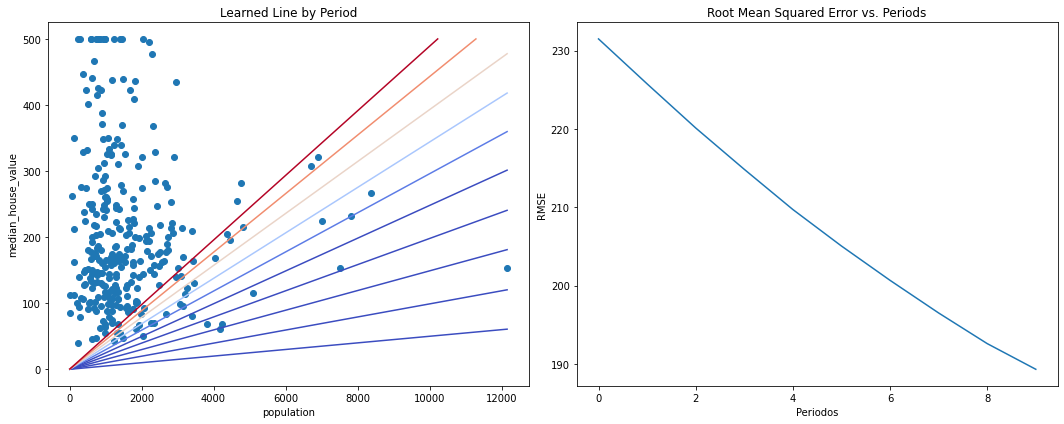

In [38]:
# def train_model(learning_rate, steps, batch_size, input_feature="total_rooms")
train_model(
    learning_rate=0.00001,
    steps=1000,
    batch_size=20,
    input_feature="population"
)

 ### Solución

Haz clic más abajo para conocer una solución posible.

Entrenando el modelo...
RMSE (en datos de entrenamiento):
  periodo 00 : 225.63
  periodo 01 : 214.62
  periodo 02 : 204.86
  periodo 03 : 196.42
  periodo 04 : 189.93
  periodo 05 : 184.46
  periodo 06 : 180.93
  periodo 07 : 178.55
  periodo 08 : 177.17
  periodo 09 : 176.26
Entrenamiento del modelo Finalizado.


,predictions,targets
count,17000.0,17000.0
mean,115.8,207.3
std,93.0,116.0
min,0.2,15.0
25%,64.0,119.4
50%,94.5,180.4
75%,139.4,265.0
max,2890.3,500.0


Final RMSE (on training data): 176.26


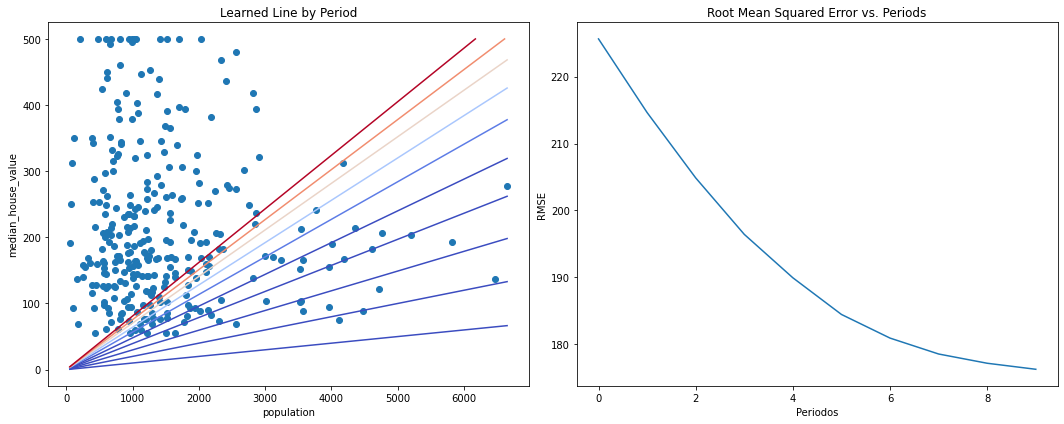

In [39]:
train_model(
    learning_rate=0.00002,
    steps=1000,
    batch_size=5,
    input_feature="population"
)